In [1]:
%pylab inline
# import numpy as np
# im just attempting to carry out 3d style transfer from a real angiogram to a synthetic angiogram by extracting features
import os, os.path
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
from torch import optim
from mpl_toolkits.axes_grid1 import make_axes_locatable


import torchvision as tv
from torchvision import transforms
import matplotlib.pyplot as plt
import math
from skimage import io


from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
os.getcwd()
print(torch.__version__)

Populating the interactive namespace from numpy and matplotlib
cuda
1.9.0+cu111


In [2]:
class myUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(myUNet, self).__init__()
        
        # encoding path
        self.convd1_1 = nn.Conv2d(in_channels,64,kernel_size=3, padding=1, bias=False)
        self.bnd1_1 = nn.BatchNorm2d(64)
        self.convd1_2 = nn.Conv2d(64,64,kernel_size=3,padding=1,bias=False)
        self.bnd1_2 = nn.BatchNorm2d(64)
        
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.convd2_1 = nn.Conv2d(64,128,kernel_size=3, padding=1, bias=False)
        self.bnd2_1 = nn.BatchNorm2d(128)
        self.convd2_2 = nn.Conv2d(128,128,kernel_size=3,padding=1,bias=False)
        self.bnd2_2 = nn.BatchNorm2d(128)
        
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.convd3_1 = nn.Conv2d(128,256,kernel_size=3, padding=1, bias=False)
        self.bnd3_1 = nn.BatchNorm2d(256)
        self.convd3_2 = nn.Conv2d(256,256,kernel_size=3,padding=1,bias=False)
        self.bnd3_2 = nn.BatchNorm2d(256)
        
        self.maxpool3 = nn.MaxPool2d(2)
        
        self.convd4_1 = nn.Conv2d(256,512,kernel_size=3, padding=1, bias=False)
        self.bnd4_1 = nn.BatchNorm2d(512)
        self.convd4_2 = nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False)
        self.bnd4_2 = nn.BatchNorm2d(512)
        
        self.maxpool4 = nn.MaxPool2d(2)
        
        self.convd5_1 = nn.Conv2d(512,1024,kernel_size=3, padding=1, bias=False)
        self.bnd5_1 = nn.BatchNorm2d(1024)
        self.convd5_2 = nn.Conv2d(1024,1024,kernel_size=3,padding=1,bias=False)
        self.bnd5_2 = nn.BatchNorm2d(1024)
        
        # expansion path
#         self.up5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.up5 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up5 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                                 nn.Conv2d(1024,512,kernel_size=1),
                                 nn.BatchNorm2d(512),
                            )
        
        self.convu4_1 = nn.Conv2d(512,512,kernel_size=3, padding=1, bias=False)
        self.bnu4_1 = nn.BatchNorm2d(512)
        self.convu4_2 = nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False)
        self.bnu4_2 = nn.BatchNorm2d(512)
        
#         self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up4 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                                 nn.Conv2d(512,256,kernel_size=1),
                                 nn.BatchNorm2d(256),
                            )
        
        self.convu3_1 = nn.Conv2d(256,256,kernel_size=3, padding=1, bias=False)
        self.bnu3_1 = nn.BatchNorm2d(256)
        self.convu3_2 = nn.Conv2d(256,256,kernel_size=3,padding=1,bias=False)
        self.bnu3_2 = nn.BatchNorm2d(256)
        
#         self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up3 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                                 nn.Conv2d(256,128,kernel_size=1),
                                 nn.BatchNorm2d(128),
                            )
        
        self.convu2_1 = nn.Conv2d(128,128,kernel_size=3, padding=1, bias=False)
        self.bnu2_1 = nn.BatchNorm2d(128)
        self.convu2_2 = nn.Conv2d(128,128,kernel_size=3,padding=1,bias=False)
        self.bnu2_2 = nn.BatchNorm2d(128)
        
#         self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up2 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                                 nn.Conv2d(128,64,kernel_size=1),
                                 nn.BatchNorm2d(64),
                            )

        
        self.convu1_1 = nn.Conv2d(64,64,kernel_size=3, padding=1, bias=False)
        self.bnu1_1 = nn.BatchNorm2d(64)
        self.convu1_2 = nn.Conv2d(64,64,kernel_size=3,padding=1,bias=False)
        self.bnu1_2 = nn.BatchNorm2d(64)
        
        self.outconv = nn.Conv2d(64,out_channels,kernel_size=1)
        
        
    def forward(self,x):
        x1 = F.relu(self.bnd1_1(self.convd1_1(x)),inplace=False)
        x1 = F.relu(self.bnd1_2(self.convd1_2(x1)),inplace=False)
        
        x2 = self.maxpool1(x1)
        
        x2 = F.relu(self.bnd2_1(self.convd2_1(x2)),inplace=False)
        x2 = F.relu(self.bnd2_2(self.convd2_2(x2)),inplace=False)
        
        x3 = self.maxpool2(x2)
        
        x3 = F.relu(self.bnd3_1(self.convd3_1(x3)),inplace=False)
        x3 = F.relu(self.bnd3_2(self.convd3_2(x3)),inplace=False)
        
        x4 = self.maxpool2(x3)
        
        x4 = F.relu(self.bnd4_1(self.convd4_1(x4)),inplace=False)
        x4 = F.relu(self.bnd4_2(self.convd4_2(x4)),inplace=False)
        
        x5 = self.maxpool2(x4)
        
        x5 = F.relu(self.bnd5_1(self.convd5_1(x5)),inplace=False)
        x5 = F.relu(self.bnd5_2(self.convd5_2(x5)),inplace=False)
        # decoding
        x4u = F.relu(self.up5(x5),inplace=False)
#         print(x4u.shape)
#         print(x4.shape)
        
        x4u = F.relu(self.bnu4_1(self.convu4_1((x4u+x4)/1.414)),inplace=False) # "residual connection"
        x4u = F.relu(self.bnu4_2(self.convu4_2(x4u)),inplace=False)
        
        x3u = F.relu(self.up4(x4u),inplace=False)
#         print(x3u.shape)
#         print(x3.shape)
        x3u = F.relu(self.bnu3_1(self.convu3_1((x3u+x3)/1.414)),inplace=False) # "residual connection"
        x3u = F.relu(self.bnu3_2(self.convu3_2(x3u)),inplace=False)
        
        x2u = F.relu(self.up3(x3u),inplace=False)
#         print(x2u.shape)
#         print(x2.shape)
        x2u = F.relu(self.bnu2_1(self.convu2_1((x2u+x2)/1.414)),inplace=False) # "residual connection"
        x2u = F.relu(self.bnu2_2(self.convu2_2(x2u)),inplace=False)
        
        x1u = F.relu(self.up2(x2u),inplace=False)
#         print(x1u.shape)
#         print(x1.shape)
        x1u = F.relu(self.bnu1_1(self.convu1_1((x1u+x1)/1.414)),inplace=False) # "residual connection"
        x1u = F.relu(self.bnu1_2(self.convu1_2(x1u)),inplace=False)
        
        return self.outconv(x1u)    
    
class cm2net(nn.Module):
    def __init__(self, stackchannels = 9, rfvchannels = 24, outchannels = 24):
        super(cm2net,self).__init__()
        def init_weights(m):
            if isinstance(m, nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
                torch.nn.init.kaiming_normal_(m.weight)
                
        self.stackpath = myUNet(stackchannels, outchannels)
        self.rfvpath = myUNet(rfvchannels, outchannels)
        self.endconv = nn.Conv2d(outchannels,outchannels, kernel_size = 3, padding = 1, bias=False)
        
        self.stackpath.apply(init_weights)
        self.rfvpath.apply(init_weights)
        self.endconv.apply(init_weights)

    def forward(self,stack,rfv):
        return self.endconv((self.stackpath(stack)+self.rfvpath(rfv))/1.414)

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        def init_weights(m):           
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
        self.double_conv.apply(init_weights)

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        torch.nn.init.kaiming_normal_(self.conv.weight,nonlinearity='relu')
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
#         def_conv = DeformableConv2d
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
#         self.dfe1 = def_conv()
        
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
#         out = {}
#         out['d0'] = self.inc(x)
#         out['d1'] = self.down1(out['d0'])
#         out['d2'] = self.down2(out['d1'])
#         out['d3'] = self.down3(out['d2'])
#         out['d4'] = self.down4(out['d3'])
#         out['u1'] = self.up1(out['d4'], out['d3'])
#         out['u2'] = self.up2(out['u1'], out['d2'])
#         out['u3'] = self.up3(out['u2'], out['d1'])
#         out['u4'] = self.up4(out['u3'], out['d0'])
#         out['output'] = self.outc(out['u4'])
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        out = self.outc(x)
        return out
            
class cm2Unet(nn.Module):
    def __init__(self, stackchannels = 9, rfvchannels = 24, outchannels = 24):
        super(cm2Unet,self).__init__()
        
        self.stackpath = UNet(stackchannels, 48)
        self.rfvpath = UNet(rfvchannels, 48)
        self.endconv = nn.Conv2d(outchannels*2,outchannels, kernel_size=3, padding=1)
        torch.nn.init.kaiming_normal_(self.endconv.weight,nonlinearity='relu')
        
    def forward(self,stack,rfv):
        return self.endconv((self.stackpath(stack)+self.rfvpath(rfv))/1.414)

model = cm2Unet()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

34558008


C:\Users\jalido\AppData\Local\Temp/ipykernel_2400/157106574.py:136: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [2]:
sqrt2 = 1.414
class resblock(nn.Module):
    def __init__(self,channels = 48):
        super(resblock,self).__init__()
        self.channels = channels
        
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1,bias=False)
        torch.nn.init.kaiming_normal_(self.conv1.weight,nonlinearity='relu')
        self.bn1 = nn.BatchNorm2d(channels)
        
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1,bias=False)
        torch.nn.init.kaiming_normal_(self.conv2.weight,nonlinearity='relu')
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self,x1):
        x1 = self.conv1(x1)
        x1 = F.relu(self.bn1(x1),inplace=True)
        x1 = self.conv2(x1)
        return (self.bn2(x1))

class cm2netblock(nn.Module):
    def __init__(self,inchannels, numblocks, outchannels = 48):
        super(cm2netblock,self).__init__()
        self.inchannels = inchannels
        self.outchannels = outchannels
        self.numblocks = numblocks
        
        self.conv1 = nn.Conv2d(inchannels,outchannels,kernel_size=3,padding=1)
        torch.nn.init.kaiming_normal_(self.conv1.weight,nonlinearity='relu')
        self.resblocks = nn.ModuleList([resblock() for i in range(numblocks)])
        self.conv2 = nn.Conv2d(outchannels,outchannels,kernel_size=3,padding=1)
        torch.nn.init.kaiming_normal_(self.conv2.weight,nonlinearity='relu')
            
    def forward(self,x):
        x0 = (self.conv1(x))
        x1 = torch.clone(x0)
        for _, modulee in enumerate(self.resblocks):
            x1 = (modulee(x1) + x1)/sqrt2
        x1 = (x1 + x0)/sqrt2
        return self.conv2(x1)
            
class cm2net(nn.Module):
    def __init__(self,numBlocks, stackchannels = 9, rfvchannels = 24, outchannels = 24):
        super(cm2net,self).__init__()
        
        self.stackpath = cm2netblock(stackchannels, numblocks = numBlocks)
        self.rfvpath = cm2netblock(rfvchannels, numblocks = numBlocks)
        self.endconv = nn.Conv2d(outchannels*2,outchannels, kernel_size=3, padding=1)
        torch.nn.init.kaiming_normal_(self.endconv.weight,nonlinearity='relu')
        
    def forward(self,stack,rfv):
        return self.endconv((self.stackpath(stack)+self.rfvpath(rfv))/sqrt2)

model = cm2net(20)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

1732872


C:\Users\jalido\AppData\Local\Temp/ipykernel_21848/4151222626.py:55: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [3]:
def load_img(path):
    meas = io.imread(path)
#     meas = (meas - meas.min()) / (meas.max() - meas.min())
    
    meas = meas/255
    return torch.from_numpy(meas)

In [7]:
# reconstruction networks

sbrnet = cm2net(20).to(device)
fsnet = cm2net(20).to(device)
# bg11d = cm2net(20).to(device)
# bgrnet = cm2net(20).to(device)
# fs_unet = UNet2(9,36).to(device)
# bg_unet = UNet2(9,36).to(device)
# fs_resnet = cm2net_resnet().to(device)
# bg_resnet = cm2net_resnet().to(device)
# unet = cm2Unet().to(device)

d_trainedmodels = 'H:/jeffrey/scattering/models/ds11/'

# for experiment (need to change input to 25)
# path = d_trainedmodels+'cm2net_bgUNET_11_layers_20'
# checkpoint2 = torch.load(path)
# unet.load_state_dict(checkpoint2['net_state_dict'])

path = d_trainedmodels+'cm2net_bg_11c_layers_20'
checkpoint2 = torch.load(path)
sbrnet.load_state_dict(checkpoint2['net_state_dict'])

# path = d_trainedmodels+'cm2net_fs_11layers_20'
# checkpoint2 = torch.load(path)
# fsnet.load_state_dict(checkpoint2['net_state_dict'])

# path = d_trainedmodels+'cm2net_bgUNET_11_layers_20'
# checkpoint2 = torch.load(path)
# print(checkpoint2.keys())
# print(checkpoint2['time'])
# bg11.load_state_dict(checkpoint2['net_state_dict'])

# path = d_trainedmodels+'yujia_cm2net_note_fs_v4_24blocks'
# checkpoint2 = torch.load(path)
# fs_resnet.load_state_dict(checkpoint2['net_state_dict'])




<All keys matched successfully>

In [6]:
# to predicting experimental 
import imageio
from PIL import Image
import skimage
import tifffile
from tifffile import TiffWriter

# bgrnet.eval()
# bg_unet.eval()
# fs_resnet.eval()
# bg_resnet.eval()
# unet.eval()
bg11_1500.eval()

fol = 'H:\\jeffrey\\scattering\\experiment\\data\\pdms 2mm phantoms\\'
scatlen = '75_2'
with torch.no_grad():
    for p in range(1,55):
        if not os.path.exists(fol+scatlen+'\\recons\\ds11\\20\\1500\\'): # 1.05 to 2
            os.mkdir(fol+scatlen+'\\recons\\ds11\\20\\1500\\')
#         # unet
#         # fs trad
#         stackin = load_img(fol+scatlen+'\\processed\\tradstack\\'+str(p)+'.tif')
#         rfvin = load_img(fol+scatlen+'\\processed\\tradrfv\\'+str(p)+'.tif')     
#         stack = torch.sigmoid(bgrnet(torch.unsqueeze(stackin,0).cuda().float(),torch.unsqueeze(rfvin,0).cuda().float()))
# #         stack = torch.sigmoid(fs_unet(torch.unsqueeze(stackin,0).cuda().float()))
#         stack = (torch.squeeze(stack.detach().to('cpu'))).numpy()
#         stack = (stack - stack.min()) / (stack.max() - stack.min())*255
#         savedir1 = fol+scatlen+'\\recons\\ds11\\20\\bgr\\'
#         savepath1 = savedir1 + str(p)+".tif"
#         print(savepath1)
#         tifffile.imsave(savepath1, stack.astype('uint8'),photometric=None)
         # unet
        stackin = load_img(fol+scatlen+'\\processed\\stackbg\\'+str(p)+'.tif')
        rfvin = load_img(fol+scatlen+'\\processed\\rfvbg\\'+str(p)+'.tif')     
        s = time.time()
        stack = torch.sigmoid(bg11_1500(torch.unsqueeze(stackin,0).cuda().float(),torch.unsqueeze(rfvin,0).cuda().float()))
        print
#         stack = torch.sigmoid(fs_unet(torch.unsqueeze(stackin,0).cuda().float()))
        stack = (torch.squeeze(stack.detach().to('cpu'))).numpy()
        stack = (stack - stack.min()) / (stack.max() - stack.min())*255
        savedir1 = fol+scatlen+'\\recons\\ds11\\20\\1500\\'
        savepath1 = savedir1 + str(p)+".tif"
        print(savepath1)
        tifffile.imsave(savepath1, stack.astype('uint8'),photometric=None)
        # bg
#         stackin = load_img(fol+scatlen+'\\processed\\stackbg\\'+str(p)+'.tif')
#         rfvin = load_img(fol+scatlen+'\\processed\\rfvbg\\'+str(p)+'.tif')        
#         stack = torch.sigmoid(bg_unet(torch.unsqueeze(stackin,0).cuda().float(),torch.unsqueeze(rfvin,0).cuda().float()))
# #         stack = torch.sigmoid(bg_unet(torch.unsqueeze(stackin,0).cuda().float()))
#         stack = (torch.squeeze(stack.detach().to('cpu'))).numpy()
#         stack = (stack - stack.min()) / (stack.max() - stack.min())*255
#         savedir1 = fol+scatlen+'\\recons\\ds11\\20\\inverse\\'
#         savepath1 = savedir1 + str(p)+"b.tif"
#         print(savepath1)
#         tifffile.imsave(savepath1, stack.astype('uint8'),photometric=None)
        
        # resnet
        # fs trad
#         stackin = load_img(fol+scatlen+'\\processed\\tradstack\\'+str(p)+'.tif')
#         rfvin = load_img(fol+scatlen+'\\processed\\tradrfv\\'+str(p)+'.tif')        
#         stack = torch.sigmoid(fs_resnet(torch.unsqueeze(stackin,0).cuda().float(),torch.unsqueeze(rfvin,0).cuda().float()))
#         stack = (torch.squeeze(stack.detach().to('cpu'))).numpy()
#         stack = (stack - stack.min()) / (stack.max() - stack.min())*255
#         savedir1 = fol+scatlen+'\\recons6\\fs\\'
#         savepath1 = savedir1 + str(p)+".tif"
#         print(savepath1)
#         tifffile.imsave(savepath1, stack.astype('uint8'),photometric=None)
#         # bg
#         stackin = load_img(fol+scatlen+'\\processed\\stackbg\\'+str(p)+'.tif')
#         rfvin = load_img(fol+scatlen+'\\processed\\rfvbg\\'+str(p)+'.tif')        
#         stack = torch.sigmoid(bg_resnet(torch.unsqueeze(stackin,0).cuda().float(),torch.unsqueeze(rfvin,0).cuda().float()))
#         stack = (torch.squeeze(stack.detach().to('cpu'))).numpy()
#         stack = (stack - stack.min()) / (stack.max() - stack.min())*255
#         savedir1 = fol+scatlen+'\\recons6\\inverse\\'
#         savepath1 = savedir1 + str(p)+".tif"
#         print(savepath1)
#         tifffile.imsave(savepath1, stack.astype('uint8'),photometric=None)



H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\1.tif
H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\2.tif
H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\3.tif
H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\4.tif
H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\5.tif
H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\6.tif
H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\7.tif
H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\8.tif
H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\9.tif
H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\10.tif
H:\jeffrey\scattering\experiment\data\pdms 2mm phantoms\75_2\recons\ds11\20\1500\11.tif
H:\jeffrey\scattering\experiment\data\pdm

FileNotFoundError: [Errno 2] No such file or directory: 'H:\\jeffrey\\scattering\\experiment\\data\\pdms 2mm phantoms\\75_2\\processed\\stackbg\\21.tif'

In [8]:
# to predicting experimental  brain slice
import imageio
from PIL import Image
import skimage
import tifffile
from tifffile import TiffWriter

sbrnet.eval()
fsnet.eval()
# fs_resnet.eval()
# bg_resnet.eval()

fol = 'H:\\jeffrey\\scattering\\experiment\\data\\brain slice\\'
scatlen = ''
with torch.no_grad():
    for p in range(1,55):
#         
# #         # fs trad
#         stackin = load_img(fol+scatlen+'\\processed\\tradstack\\'+str(p)+'.tif')
#         rfvin = load_img(fol+scatlen+'\\processed\\tradrfv\\'+str(p)+'.tif')     
#         stack = torch.sigmoid(fsnet(torch.unsqueeze(stackin,0).cuda().float(),torch.unsqueeze(rfvin,0).cuda().float()))
# #         stack = torch.sigmoid(fs_unet(torch.unsqueeze(stackin,0).cuda().float()))
#         stack = (torch.squeeze(stack.detach().to('cpu'))).numpy()
#         stack = (stack - stack.min()) / (stack.max() - stack.min())*255
#         savedir1 = fol+scatlen+'\\recons\\sbrnet\\'
#         savepath1 = savedir1 + str(p)+".tif"
#         print(savepath1)
#         tifffile.imsave(savepath1, stack.astype('uint8'),photometric=None)
        # bg
        stackin = load_img(fol+scatlen+'\\processed\\stackbg\\'+str(p)+'.tif')
        rfvin = load_img(fol+scatlen+'\\processed\\rfvbg\\'+str(p)+'.tif')        
        stack = torch.sigmoid(sbrnet(torch.unsqueeze(stackin,0).cuda().float(),torch.unsqueeze(rfvin,0).cuda().float()))
#         stack = torch.sigmoid(bg_unet(torch.unsqueeze(stackin,0).cuda().float()))
        stack = (torch.squeeze(stack.detach().to('cpu'))).numpy()
        stack = (stack - stack.min()) / (stack.max() - stack.min())*255
        savedir1 = fol+scatlen+'\\recons\\sbrnethigh\\'
        savepath1 = savedir1 + str(p)+".tif"
        print(savepath1)
        tifffile.imsave(savepath1, stack.astype('uint8'),photometric=None)




H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\1.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\2.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\3.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\4.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\5.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\6.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\7.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\8.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\9.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\10.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\11.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\12.tif
H:\jeffrey\scattering\experiment\data\brain slice\\recons\sbrnethigh\13.tif
H:\jeffrey\scattering

FileNotFoundError: [Errno 2] No such file or directory: 'H:\\jeffrey\\scattering\\experiment\\data\\brain slice\\processed\\stackbg\\23.tif'

In [11]:
# to predicting experimental and evaluating inference time
import imageio
from PIL import Image
import skimage
import tifffile
from tifffile import TiffWriter

# bgrnet.eval()
# bg_unet.eval()
# fs_resnet.eval()
# bg_resnet.eval()
bg11d.eval()

fol = 'H:\\jeffrey\\scattering\\experiment\\data\\pdms 2mm phantoms\\'
scatlen = '75_2'
timee = 0
count = 0
with torch.no_grad():
    for p in range(1,10):
        
        stackin = load_img(fol+scatlen+'\\processed\\stackbg\\'+str(p)+'.tif')
        rfvin = load_img(fol+scatlen+'\\processed\\rfvbg\\'+str(p)+'.tif')     
        s = time.time()
        stack = torch.sigmoid(bg11d(torch.unsqueeze(stackin,0).cuda().float(),torch.unsqueeze(rfvin,0).cuda().float()))
#         print(time.time()-s)
        timee += time.time()-s
        count += 1


print(timee/count)

0.11115805308024089


0.0002681864
0.00024951645
0.0002476879


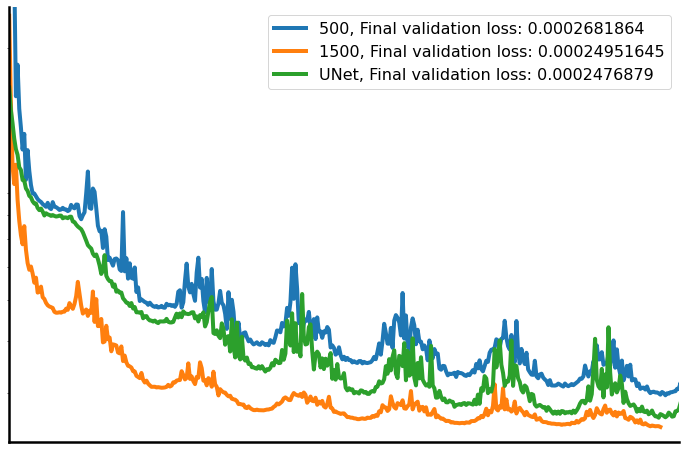

In [27]:
# for validation loss of sbr net 500, sbrnet 1500, and unet 
# reconstruction networks

sbrnet500 = cm2net(20).to(device)
sbrnet1500 = cm2net(20).to(device)
sbrunet = cm2Unet()


d_trainedmodels = 'H:/jeffrey/scattering/models/ds11/'


path = d_trainedmodels+'cm2net_bg_layers_20'
checkpoint2 = torch.load(path)
# sbrnet500.load_state_dict(checkpoint2['net_state_dict'])
val500 = checkpoint2['valloss']

path = d_trainedmodels+'cm2net_bg_11_1500_layers_20'
checkpoint2 = torch.load(path)
# sbrnet1500.load_state_dict(checkpoint2['net_state_dict'])
val1500 = checkpoint2['valloss']

path = d_trainedmodels+'cm2net_bgUNET_11_layers_20'
checkpoint2 = torch.load(path)
# sbrunet.load_state_dict(checkpoint2['net_state_dict'])

# print(checkpoint2.keys())
valunet = checkpoint2['valloss']

# plotting
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(val500,label='500, '+'Final validation loss: '+str(val500[-1].numpy()),linewidth = 4)
plt.plot(val1500,label='1500, '+'Final validation loss: '+str(val1500[-1].numpy()),linewidth = 4)
plt.plot(valunet,label='UNet, '+'Final validation loss: '+str(valunet[-1].numpy()),linewidth = 4)
plt.yscale("log") 
xlim(0,400)
ylim(0.00023,0.0025)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14,)
ax.tick_params(width=3, length=6)
# plt.xlabel('Epoch',fontsize=18)
# plt.ylabel('Validation loss',fontsize=18)
# plt.grid(True, which="both",linewidth=2,alpha = 0.7)

csfont = {'fontname':'Arial'}
hfont = {'fontname':'Arial'}

# plt.title('title',**csfont)
# plt.xlabel('Epoch', **hfont)
legend(prop={'size': 16})
[x.set_linewidth(2.5) for x in ax.spines.values()]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(left = False, right = False , labelleft = False,
                labelbottom = False, bottom = False)
plt.savefig("vallossSI.svg",format='svg')
print(str(val500[-1].numpy()))
print(str(val1500[-1].numpy()))
print(str(valunet[-1].numpy()))